# XGBRegressor Test

#### Failed model that fits to 'used_cars.csv'

In [733]:
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import make_scorer, r2_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve, learning_curve, train_test_split
from scipy.stats import uniform

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import seaborn as sns; sns.set()
# Suppress the SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)
plt.rcParams['figure.figsize'] = (6, 4)

In [734]:
# Load the data
df = pd.read_csv('used_cars.csv')

In [735]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [736]:
df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714 mi.,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,"$349,950"
4005,Audi,S4 3.0T Premium Plus,2022,"10,900 mi.",Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,"$53,900"
4006,Porsche,Taycan,2022,"2,116 mi.",NaN,Electric,Automatic,Black,Black,None reported,NaN,"$90,998"
4007,Ford,F-150 Raptor,2020,"33,000 mi.",Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,"$62,999"


In [737]:
#drop null values
df = df.dropna()

In [738]:
#clean up price column
df['price'] = df['price'].str.replace(r'\D', '', regex=True).astype(int)

In [739]:
#clean up mileage column
df['milage'] = df['milage'].str.replace(r'[^\d]', '', regex=True).astype(int)


In [740]:
#drop clean title column
df = df.drop(columns=['clean_title'])

In [741]:
# Function to parse engine specs
def parse_engine_specs(specs):
    match = re.match(r'(?P<hp>\d+\.?\d*)HP (?P<engine_size>\d+\.\d+L) (?P<engine_type>.+)', specs)
    if match:
        return match.groupdict()
    return {
        'hp': None,
        'engine_size': None,
        'engine_type': None
}

In [742]:
# Apply function to extract data into new columns
parsed_df = df['engine'].apply(parse_engine_specs).apply(pd.Series)

# Join the parsed DataFrame with the original DataFrame
df = df.join(parsed_df)

# Drop the original engine column
df = df.drop(columns=['engine'])
df = df.dropna()

In [743]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2980 entries, 0 to 4008
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         2980 non-null   object
 1   model         2980 non-null   object
 2   model_year    2980 non-null   int64 
 3   milage        2980 non-null   int64 
 4   fuel_type     2980 non-null   object
 5   transmission  2980 non-null   object
 6   ext_col       2980 non-null   object
 7   int_col       2980 non-null   object
 8   accident      2980 non-null   object
 9   price         2980 non-null   int64 
 10  hp            2980 non-null   object
 11  engine_size   2980 non-null   object
 12  engine_type   2980 non-null   object
dtypes: int64(3), object(10)
memory usage: 325.9+ KB


In [744]:
df

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,price,hp,engine_size,engine_type
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,6-Speed A/T,Black,Black,At least 1 accident or damage reported,10300,300.0,3.7L,V6 Cylinder Engine Flex Fuel Capability
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,7-Speed A/T,Black,Black,None reported,15500,354.0,3.5L,V6 Cylinder Engine Gas/Electric Hybrid
6,Audi,S3 2.0T Premium Plus,2017,84000,Gasoline,6-Speed A/T,Blue,Black,None reported,31000,292.0,2.0L,4 Cylinder Engine Gasoline Fuel
7,BMW,740 iL,2001,242000,Gasoline,A/T,Green,Green,None reported,7300,282.0,4.4L,8 Cylinder Engine Gasoline Fuel
8,Lexus,RC 350 F Sport,2021,23436,Gasoline,6-Speed A/T,Black,Black,None reported,41927,311.0,3.5L,V6 Cylinder Engine Gasoline Fuel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,Mercedes-Benz,AMG GLS 63 4MATIC,2023,2000,Hybrid,9-Speed A/T,Gray,Beige,None reported,175000,603.0,4.0L,8 Cylinder Engine Gasoline/Mild Electric Hybrid
4003,Mercedes-Benz,E-Class E 300 4MATIC,2018,53705,Gasoline,A/T,Black,Black,At least 1 accident or damage reported,25900,241.0,2.0L,4 Cylinder Engine Gasoline Fuel
4005,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,53900,349.0,3.0L,V6 Cylinder Engine Gasoline Fuel
4007,Ford,F-150 Raptor,2020,33000,Gasoline,A/T,Blue,Black,None reported,62999,450.0,3.5L,V6 Cylinder Engine Gasoline Fuel


In [745]:
print(df.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
hp              0
engine_size     0
engine_type     0
dtype: int64


In [746]:
df.nunique()

brand             51
model           1504
model_year        29
milage          1937
fuel_type          5
transmission      15
ext_col           14
int_col           13
accident           2
price            993
hp               332
engine_size       59
engine_type       30
dtype: int64

In [747]:
#encoding categorical data

In [748]:
# Columns to encode with Label Encoding
label_encode_columns = ['brand', 'model', 'model_year', 'milage', 'hp', 'engine_size', 'engine_type', 'transmission', 'ext_col', 'int_col', 'accident']

# Columns to scale (ensure these columns are numeric and exclude 'price')
scale_columns = ['milage', 'hp', 'engine_size']

# 1. Label Encoding for specified columns
le = LabelEncoder()
for col in label_encode_columns:
    if col != 'price':  # Don't encode the target variable
        df[col] = le.fit_transform(df[col])


df = df.drop(columns=['fuel_type'])


# 3. Scaling the numeric columns (excluding 'price')
scaler = StandardScaler()  # Or use MinMaxScaler() if preferred
df[scale_columns] = scaler.fit_transform(df[scale_columns])

In [749]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2980 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         2980 non-null   int64  
 1   model         2980 non-null   int64  
 2   model_year    2980 non-null   int64  
 3   milage        2980 non-null   float64
 4   transmission  2980 non-null   int64  
 5   ext_col       2980 non-null   int64  
 6   int_col       2980 non-null   int64  
 7   accident      2980 non-null   int64  
 8   price         2980 non-null   int64  
 9   hp            2980 non-null   float64
 10  engine_size   2980 non-null   float64
 11  engine_type   2980 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 302.7 KB


In [750]:
df

,brand,model,model_year,milage,transmission,ext_col,int_col,accident,price,hp,engine_size,engine_type
0,13,1376,17,-0.351635,4,1,1,0,10300,-0.128824,-0.024318,25
3,19,968,19,0.546123,6,1,1,1,15500,0.408959,-0.186617,26
6,3,1144,21,0.442464,4,2,1,1,31000,-0.211559,-1.241560,8
7,4,109,5,1.740048,10,6,6,1,7300,-0.335663,0.462579,16
8,25,1011,25,-1.073543,4,1,1,1,41927,-0.004720,-0.186617,27
...,...,...,...,...,...,...,...,...,...,...,...,...
4002,33,194,27,-1.712154,9,5,0,1,175000,1.953361,0.219131,17
4003,33,442,22,-0.275742,10,1,1,0,25900,-0.790710,-1.241560,8
4005,3,1148,26,-1.440050,14,1,1,1,53900,0.367591,-0.511214,27
4007,13,541,24,-0.825503,10,2,1,1,62999,1.139792,-0.186617,27


In [751]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2980 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         2980 non-null   int64  
 1   model         2980 non-null   int64  
 2   model_year    2980 non-null   int64  
 3   milage        2980 non-null   float64
 4   transmission  2980 non-null   int64  
 5   ext_col       2980 non-null   int64  
 6   int_col       2980 non-null   int64  
 7   accident      2980 non-null   int64  
 8   price         2980 non-null   int64  
 9   hp            2980 non-null   float64
 10  engine_size   2980 non-null   float64
 11  engine_type   2980 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 302.7 KB


## Split the data into features and target

In [752]:
X = df.drop(columns=['price'])

In [753]:
y = df['price']

In [754]:
X.head()

,brand,model,model_year,milage,transmission,ext_col,int_col,accident,hp,engine_size,engine_type
0,13,1376,17,-0.351635,4,1,1,0,-0.128824,-0.024318,25
3,19,968,19,0.546123,6,1,1,1,0.408959,-0.186617,26
6,3,1144,21,0.442464,4,2,1,1,-0.211559,-1.241560,8
7,4,109,5,1.740048,10,6,6,1,-0.335663,0.462579,16
8,25,1011,25,-1.073543,4,1,1,1,-0.004720,-0.186617,27


In [755]:
y.head()

0    10300
3    15500
6    31000
7     7300
8    41927
Name: price, dtype: int64

In [756]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4700)

In [757]:
xgb = XGBRegressor(objective='reg:squarederror')

In [758]:
param_distributions = {
    'max_depth': range(3, 12),
    'n_estimators': range(10, 201, 10),
    'learning_rate': np.linspace(0.001, 0.05, 35),
    'subsample': np.linspace(0.5, 1.0, 6),
    # 'colsample_bytree': [0.5, 0.8, 1.0],
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'reg_lambda': np.linspace(0.05, 2.0, 50),
}

In [759]:
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_distributions,
    n_iter=300,
    scoring=make_scorer(r2_score),
    cv=5,
    n_jobs=-1,
    random_state=4700
)

In [760]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       1.04489796, 1.08469388, 1.1244898 , 1.16428571, 1.20408163,
       1.24387755, 1.28367347, 1.32346939, 1.36326531, 1.40306122,
       1.44285714, 1.48265306, 1.52244898, 1.5622449 , 1.60204082,
       1.64183673, 1.68163265, 1.72142857, 1.76122449, 1.80102041,
       1.84081633, 1.88061224, 1.92040816, 1.96020408, 2.        ]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=4700,
                   scoring=make_scorer(r2_score, response_method='predict'))

In [761]:
best_model = random_search.best_estimator_

In [762]:
print('Best hyperparameters:', random_search.best_params_)
print('Best R^2:', random_search.best_score_)

Best hyperparameters: {'subsample': 0.6, 'reg_lambda': 1.8806122448979592, 'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best R^2: 0.5471431475477009


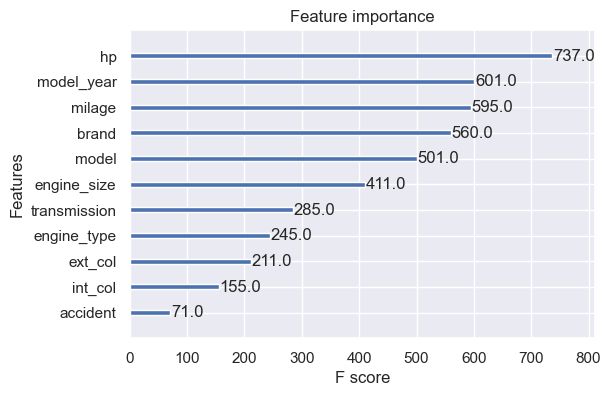

In [763]:
plot_importance(best_model)
plt.show()